# 01_1_DESIGN_Promoters

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/01_1_DESIGN_Promoters.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

In [1]:
%%capture
!pip install pydna
!pip install constrain
!pip install matplotlib
!pip install seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 1. Intro

Promoters are a major component of protein expression and are a key driver of biological systems (Kotopka & Smolke, 2020). To make a library with diversity and unique expression levels and kinetics I want to look for characteristics such as:  

- High/low constitutive expression
- Increase/decrease in expression over time.

**We want to automate and standardize the selection process with an algorithm**

**About the Data used here**:
Selection can be automated from RNA-seq data, where mRNAs are sequenced, mapped to specific genes, and added to a count matrix. It is important to note that this method could be modified and applied to other data sets or organisms.
In S. cerevisiae, promoters are defined as the 1kb upstream of the transcriptional start site (TSS)(a lab standard) and therefore make them easy to retrieve. The RNA-seq data used here was generated by Arun et al (Rajkumar et al., 2019) and the data is composed of three columns representing time points i.e samples taken at 6 hours, 12, hours and 24 hours. The 6303 rows represent the genes of S. cerevisiae and each has RNA counts for each of the time points. 

**The method for finding the set of promoters we're interesed is described as follows:**

1. Load in RNA-seq data
2. Pre-process the data i.e sort, remove irrelevant data points(zero counts), and set a lower limit for what is considered low-expression, etc. 
3. Consider what expression dynamics are interesting and search through the pre-processed data
4. Save best candidates in each group of expression dynamics.
5. Retrieve the sequences of these (Upstream sequences of TSS) from the sequence database. 
6. Align the sequences to avoid homology. 
7. Chosen promoters should be saved and exported as FASTA (to an external database). 


## 2. Data-processing

First step in this workflow is to read the RNAseq data in. 

In [4]:
df = pd.read_csv('ConStrain_on_google_colab/Data/RNA_seq_data/RNAseq_reads_arun.csv', index_col=0)

In [5]:
df

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAL067W-A,3.455130,2.519210,5.707320
YAL064W-B,0.000000,0.000000,0.000000
YAL064W,4.640590,2.375570,8.673990
GDH3,22.330000,10.552100,41.387300
BDH2,72.564100,48.697600,120.082000
...,...,...,...
tV(UAC)Q,0.000000,0.000000,0.000000
COX3,0.122102,0.153141,0.155030
tM(CAU)Q2,0.000000,0.000000,0.000000


Then we can sort all values

In [6]:
df.sort_values(by=['NIL_6h_FPKM'], ascending = False)

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
RPL41B,14291.10,17886.20,10638.800
SPO24,8863.45,4976.59,15027.100
YDR524W-A,5996.15,8357.58,3777.040
RPL41A,5696.18,8116.95,2164.460
TDH3,5623.80,5198.45,845.219
...,...,...,...
tD(GUC)J3,0.00,0.00,0.000
tR(UCU)J2,0.00,0.00,0.000
EMT5,0.00,0.00,0.000


It turns out we have a many of genes that do not have any counts in the dataset. We are not interested in these genes since they are most likely controlled by inducible promoters so we filter them out. 

### 2.1 Removing zeros from the dataset

In [7]:
df = df.loc[~(df==0).all(axis=1)]
df

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAL067W-A,3.455130,2.519210,5.707320
YAL064W,4.640590,2.375570,8.673990
GDH3,22.330000,10.552100,41.387300
BDH2,72.564100,48.697600,120.082000
BDH1,169.859000,43.289800,282.497000
...,...,...,...
21S_RRNA,0.240608,0.261625,0.234314
SCEI,0.091711,0.000000,0.000000
COX2,0.031348,0.000000,0.000000


After filtering all the genes out that were only zero, I notice that there are still some genes with close to zero counts but we will deal with that later. Lets plot the data. 

### 2.2 Plotting the data with counts (y-axis) and genes (x-axis)

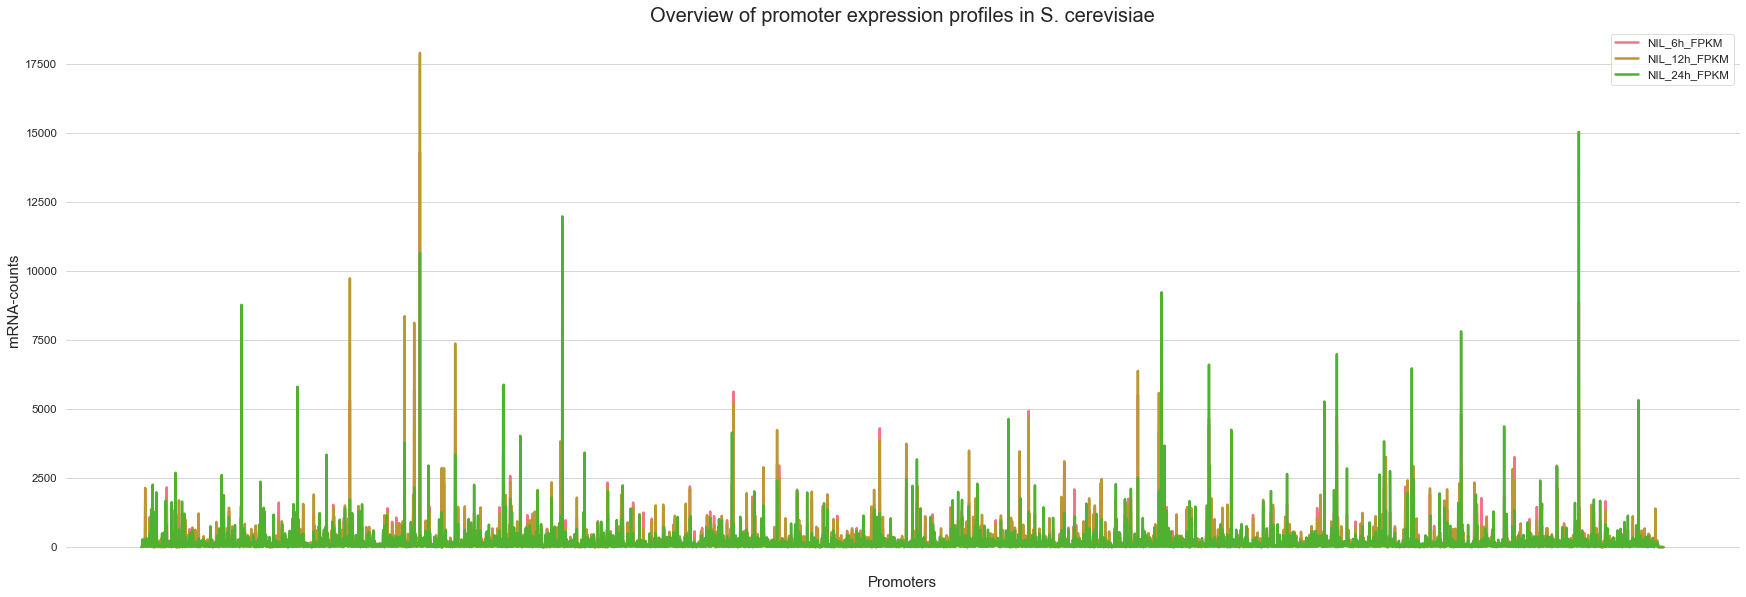

In [8]:
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_palette("husl")
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 2.5})

df.plot(legend = True, figsize=(30, 10))
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Overview of promoter expression profiles in S. cerevisiae", fontsize = 20)
plt.xlabel("Promoters",fontsize = 15)
plt.ylabel("mRNA-counts", fontsize = 15)


# removes the borders around the plot
sns.despine(bottom = True, left = True)
ax = plt.gca()
ax.axes.xaxis.set_ticks([])

plt.grid(True)

#plt.savefig('../pictures/Overview_of_promoter_expression profiles.png', dpi = 200)

The plotted data shows us that there are approximately 20 genes that at some point in during the have RNA counts of >5000. Most other genes are found to have < 1000 counts.  

Additionally, as we saw before quite a lot of data points have RNA counts close to zero and as we are not interested in promoters that do not express anyhting. They can be filtered out. 

I choose to put a threshold expression level - arbitrarily chosen and can differ from dataset to dataset. Genes with counts less than 2000 counts combined from all timepoints were filtered out.  


In [9]:
threshold = 640
df_with_threshold = df[df['NIL_6h_FPKM']+ df['NIL_12h_FPKM']+ df['NIL_24h_FPKM'] > threshold]
df_with_threshold

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAL044W-A,245.231,267.378,274.042
CDC19,1632.650,2142.150,101.161
SNC1,279.743,290.354,321.153
EFB1,1088.300,970.904,487.837
ADE1,884.882,542.645,1367.400
...,...,...,...
RPC40,293.395,433.721,152.376
ANT1,215.003,274.217,205.789
YPR148C,291.884,334.582,314.950


This step filtered out most of the genes with 1089 remaining promoters. With this amount of promoters let's look at the dynamics in a line-diagram to get an understanding how they increase or decrease over time

Sorting the values of the dataframe

In [10]:
df_with_threshold = df_with_threshold.sort_values(by=['NIL_6h_FPKM', 'NIL_12h_FPKM', 'NIL_24h_FPKM'], ascending = False)
df_with_threshold.head()

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
RPL41B,14291.10,17886.20,10638.800
SPO24,8863.45,4976.59,15027.100
YDR524W-A,5996.15,8357.58,3777.040
RPL41A,5696.18,8116.95,2164.460
TDH3,5623.80,5198.45,845.219


### 2.3 Selecting the top 15 promoters in each category (HIGH/LOW constitutive expression) to perform an alignment

We can pick 15 genes with the highest counts and 15 genes with lowest counts and make them into a list

In [11]:
# Selecting top15
List_of_Top15_High_constitutive_prom = df_with_threshold[:15]
List_of_Top15_Low_constitutive_prom = df_with_threshold[-15:] 

# making them into a list
List_of_Top15_High_constitutive_promoters = List_of_Top15_High_constitutive_prom.index.values.tolist() 
List_of_Top15_Low_constitutive_promoters = List_of_Top15_Low_constitutive_prom.index.values.tolist()

In [12]:
print(List_of_Top15_High_constitutive_promoters)
print(List_of_Top15_Low_constitutive_promoters)

['RPL41B', 'SPO24', 'YDR524W-A', 'RPL41A', 'TDH3', 'CCW12', 'SED1', 'ICL1', 'FBA1', 'YBR085C-A', 'YDR134C', 'YOR302W', 'NCE103', 'SNZ1', 'RPL39']
['MRPL10', 'YBR016W', 'NFU1', 'TIP1', 'AIM7', 'GPA1', 'AUA1', 'DAK1', 'RPL15B', 'ATG8', 'GID8', 'IRC23', 'YJR154W', 'ICL2', 'YAR035C-A']


Now, as we have a lot experience and have the promoter CYC1 and URE2 available, it will be added to the list of constitutive HIGH expression and constritutuve LOW expression promoters respectively.


In [13]:
List_of_Top15_High_constitutive_promoters.append('CYC1')
List_of_Top15_Low_constitutive_promoters.append('URE2')

### 2.4 Selecting the top 15 promoters in each category (DECREASING expression) to perform an alignment
We can look for genes that have the highest/increase increase relative to the first timepoint.

We can investigate genes that have show the greatets difference in counts from 6 hour to 24 hour

We can pick these dynamics by:
    
1. Find genes were expression increase from 6 - 24 hour timepoint in mRNA counts 
    - This method is good at capturing decreases in expression 
2. Do the same but where we calculate the relative increase (in %) from first to last timepoint. 
    - This method is good at capturing increases in expression 
    - Poor at getting decreases because the relative points will only go to -1 and doestnt capture steep decreases. See table below: 
    
    
    
    
|                      | 6 hour | 24 hour  | % diff relative to first timepoint |   |
|----------------------|--------|----------|------------------------------------|---|
| mRNA counts - gene x | 5000   | 50       | -0.99                             |   |
| mRNA counts - gene y | 100    | 1        | -0.99                             |   |
|                      |        |          |                                    |   |    

With this in mind we mix the methods by picking INCREASING promoters with relative increase in & and pick DECREASING promoters with mRNA count differences. 

Getting the one that has the steepest decrease in expression and steepest increase in expression with the pandas idmax function

In [14]:
print((df_with_threshold['NIL_6h_FPKM'] - df_with_threshold['NIL_24h_FPKM']).idxmax())
print((df_with_threshold['NIL_24h_FPKM'] - df_with_threshold['NIL_6h_FPKM']).idxmax())

TDH3
ICL1


Find difference from first column to the last column: 


In [15]:
# Lets only look at the difference between 6 and 24 hour.
df_with_DIFF_over_time_increasing = df_with_threshold[['NIL_6h_FPKM','NIL_24h_FPKM']]

In [16]:
# Find the difference between the columns
df_with_DIFF_over_time_increasing = df_with_DIFF_over_time_increasing.diff(axis='columns')

# Sort the dataframe
df_with_DIFF_over_time_increasing = df_with_DIFF_over_time_increasing.sort_values(by=['NIL_24h_FPKM' ], ascending = False)

# # df_with_change_over_time
df_with_DIFF_over_time_increasing.tail(20)

,NIL_6h_FPKM,NIL_24h_FPKM
gene_short_name,,
RPL25,NaN,-1528.8200
CDC19,NaN,-1531.4890
YDR134C,NaN,-1556.0600
YDR524C-B,NaN,-1585.6800
RPS5,NaN,-1609.8520
RPS28A,NaN,-1685.1020
RPL10,NaN,-1716.1800
RPS30B,NaN,-1919.9100
TPI1,NaN,-2055.6160


### 2.5 Selecting the top 15 promoters in each category (INCREASING expression) to perform an alignment


In [17]:
df_with_change_over_time = df_with_threshold.pct_change(axis='columns')
df_with_change_over_time_increasing = df_with_change_over_time.sort_values(by=[ 'NIL_12h_FPKM','NIL_24h_FPKM' ], ascending = True)

# df_with_change_over_time
df_with_change_over_time_increasing

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAR035C-A,NaN,-1.000000,inf
MLS1,NaN,-0.996357,649.677485
PCK1,NaN,-0.994967,471.973855
SFC1,NaN,-0.988483,210.280874
ADY2,NaN,-0.987649,199.421709
...,...,...,...
RIB4,NaN,0.906627,-0.870206
MET28,NaN,0.948386,-0.849363
PRM5,NaN,0.959731,-0.843176


KEEP in mind that it only is relative to the adjacent timepoint and not the first timepoint. The top and botton can be picked from the dataframe: 


In [18]:
# Selecting top5
Top15_increasing_promoters = df_with_change_over_time_increasing[:15]
Top15_decreasing_promoters = df_with_DIFF_over_time_increasing[-15:]

# Making it into a list 
List_of_Top15_increasing_promoters = Top15_increasing_promoters.index.values.tolist() 
List_of_Top15_descreasing_promoters = Top15_decreasing_promoters.index.values.tolist()
print(List_of_Top15_increasing_promoters)
print(List_of_Top15_descreasing_promoters)

['YAR035C-A', 'MLS1', 'PCK1', 'SFC1', 'ADY2', 'IDP2', 'ACS1', 'ICL1', 'REG2', 'SPG4', 'HXT5', 'YGR067C', 'JEN1', 'YNR034W-A', 'ACH1']
['RPS28A', 'RPL10', 'RPS30B', 'TPI1', 'RPS30A', 'YDR524W-A', 'ENO2', 'CCW12', 'GPM1', 'RPL39', 'RPL41A', 'SED1', 'FBA1', 'RPL41B', 'TDH3']


In [19]:
all_promoters_we_have_found = List_of_Top15_High_constitutive_promoters + List_of_Top15_Low_constitutive_promoters + List_of_Top15_increasing_promoters+ List_of_Top15_descreasing_promoters

In [20]:
len(all_promoters_we_have_found)

62

## 3. Fetching promoter sequences with Intermine

#### 3.1 We can now fetch the 1kb upstream of these promoters with the following fucntions directly from intermines databases:  

In [21]:
%%capture
!pip install intermine

In [22]:
from __future__ import print_function
from intermine.webservice import Service

In [23]:
def FetchPromoter(promoter_name:str): 
    seq = ''
    service = Service("https://yeastmine.yeastgenome.org/yeastmine/service")
    query = service.new_query("Gene")
    query.add_view(
        "secondaryIdentifier", "symbol", "length", "flankingRegions.direction",
        "flankingRegions.sequence.length", "flankingRegions.sequence.residues"
    )

    query.add_constraint("Gene", "LOOKUP", promoter_name, "S. cerevisiae", code="B")
    query.add_constraint("flankingRegions.direction", "=", "upstream", code="C")
    query.add_constraint("flankingRegions.distance", "=", "1.0kb", code="A")
    query.add_constraint("flankingRegions.includeGene", "=", "false", code="D")

    for row in query.rows():
        seq = row["flankingRegions.sequence.residues"]

    return seq

In [24]:
%%capture
!pip install Bio

In [25]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [26]:
%%time
def FetchMultiplePromoters(List_of_promoter_names):
    # #initializing 
    LIST_OF_BIOrecord_objects = []

    for i in range(0, len(List_of_promoter_names)):
        #fetching the seqs
        promoters_seq = SeqRecord(Seq(FetchPromoter(List_of_promoter_names[i])))
        promoters_seq.name = str(List_of_promoter_names[i])+ ' Promoter'
        promoters_seq.id = str(List_of_promoter_names[i])
        promoters_seq.description = 'Defined as being 1kb upstream of the TSS and fetched from Intermines API'

        # Append to list 
        LIST_OF_BIOrecord_objects.append(promoters_seq)
    
    return LIST_OF_BIOrecord_objects

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


In [27]:
print(List_of_Top15_increasing_promoters)
print(List_of_Top15_descreasing_promoters)

print(List_of_Top15_High_constitutive_promoters)
print(List_of_Top15_Low_constitutive_promoters)

['YAR035C-A', 'MLS1', 'PCK1', 'SFC1', 'ADY2', 'IDP2', 'ACS1', 'ICL1', 'REG2', 'SPG4', 'HXT5', 'YGR067C', 'JEN1', 'YNR034W-A', 'ACH1']
['RPS28A', 'RPL10', 'RPS30B', 'TPI1', 'RPS30A', 'YDR524W-A', 'ENO2', 'CCW12', 'GPM1', 'RPL39', 'RPL41A', 'SED1', 'FBA1', 'RPL41B', 'TDH3']
['RPL41B', 'SPO24', 'YDR524W-A', 'RPL41A', 'TDH3', 'CCW12', 'SED1', 'ICL1', 'FBA1', 'YBR085C-A', 'YDR134C', 'YOR302W', 'NCE103', 'SNZ1', 'RPL39', 'CYC1']
['MRPL10', 'YBR016W', 'NFU1', 'TIP1', 'AIM7', 'GPA1', 'AUA1', 'DAK1', 'RPL15B', 'ATG8', 'GID8', 'IRC23', 'YJR154W', 'ICL2', 'YAR035C-A', 'URE2']


Here the function "FetchMultiplePromoters" is just applied to each of the lists of promoters

In [28]:
%%time
Indcreasing_promoters = FetchMultiplePromoters(List_of_Top15_increasing_promoters)
Decreasing_promoters = FetchMultiplePromoters(List_of_Top15_descreasing_promoters)

High_constitutive_promoters = FetchMultiplePromoters(List_of_Top15_High_constitutive_promoters)
Low_constitutive_promoters = FetchMultiplePromoters(List_of_Top15_Low_constitutive_promoters)

CPU times: user 3.69 s, sys: 922 ms, total: 4.61 s
Wall time: 2min 47s


In [29]:
Decreasing_promoters[0]

SeqRecord(seq=Seq('TTGTGGGTTTTCACCCACTTTATGCAAATCACCTAGGAAACCTTCATTGAACAT...ATC'), id='RPS28A', name='RPS28A Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[])

In [30]:
Indcreasing_promoters[0].name

'YAR035C-A Promoter'

In [31]:
High_constitutive_promoters[0].name

'RPL41B Promoter'

In [32]:
Low_constitutive_promoters[4].id

'AIM7'

## 4. Check for Homology between promoters with multiple sequence alingment 

In [33]:
from Bio.Align import MultipleSeqAlignment
All_promoters = Indcreasing_promoters + Decreasing_promoters + High_constitutive_promoters + Low_constitutive_promoters

align = MultipleSeqAlignment(All_promoters)
for record in align:
    print(record.seq[0:100] + " " + record.id)# print(align.substitutions)

CCCTGGTGGCCCTTTCCAATAGTTTTTTCAGTTCGATGTCGATGGCGATCTTGGTGTTGGTGGCGGTGTCGTTTTCATTGACTTTCCTAACGAGCTCGAT YAR035C-A
TTTAATCTTTAGGGAGGGTAAAGTTGGATTCATCAATTTGATGAAATCCGTGTAAAACCATGAGGCTTCTTCAAAATGAAATAACTCTCTCTCGACACTC MLS1
ACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAGAGAGTGCCAGCGAACCGCGTCTTTCCCCTCGCCGCTTTAACTACGTA PCK1
CCGGTGGTGCTTATACTGTTTCTACTGCAGCTGCCGCTACTGTTAGATCTACCATCAGAAGATTAAGAGAAATGGTTGAAGCTTAAACTTCTTTCATTCA SFC1
ACCTTGGGATATCGTTGGAAATCCTAACCATCGGCATAATTTTTGAAGACTTGAATAACTCCATAATATTAAGCGTGCTGGTGCTTTTGGGCTCACTACT ADY2
AATAGTCTTACACCAATGAGCCAAATAGTGAATGCGGTCCTGAACCAGAACGAGACTGTTACGTTCGCAGCAAGAGGCCATGTCCTTGAAGATGGTATAG IDP2
AAGTGGTCTGCAAATGCTTTGCAGACGCCGGAGTAGTGTCGTTTGTGTCAGAGGAACGTGCTGTACCGCTGCACAGTACGAAACACGTTAAAAGGCACCT ACS1
TGGAAATGTAAAGGATAATGAGTGAGCATATAAAATGGAAGAAAAAATAATAATAGGATTATGTATAAAATATCGATTCCCTTTTGTAGATTTCGAGATC ICL1
GGAAAAGAGGCAGCCAAAGTCGCCAAAACTAATGCAGATTTTTCCTATAAAATCCTAACAAGAGAAACGTTGGTTGAGTACGATTACTACTTATTCGGAA REG2
AGGAGTCTTATGTGACAGCACTTGCGTTATTGTCAGCCGGA

With biopython it is possible to align sequences in what is termed a "DUMMY ALIGNMENT" - see below

In [34]:
from Bio.Align import AlignInfo
summary_align = AlignInfo.SummaryInfo(align)
gap_consensus = summary_align.gap_consensus()
consensus = summary_align.dumb_consensus( threshold=0.7)
print(consensus)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAXX

In [35]:
counter = 0
for nucleotide in consensus: 
    if nucleotide != 'X': 
        counter += 1
        
print('Amount of consensus with a 70% threshold: ', (counter/len(consensus))*100, '%')
print('Nucleotides that are the same at a 70% threshold:', counter)

Amount of consensus with a 70% threshold:  0.1 %
Nucleotides that are the same at a 70% threshold: 1


Another way of showing if the sequences are homologous is to use other online tools. 
One of these toos is to use the Mview online tool: https://www.ebi.ac.uk/Tools/msa/mview/
 
You just simply upload the fasta file with all sequences

In [36]:
all_promoter_names = []
for names in All_promoters:
    print(names.name)
    all_promoter_names.append(names.id)

YAR035C-A Promoter
MLS1 Promoter
PCK1 Promoter
SFC1 Promoter
ADY2 Promoter
IDP2 Promoter
ACS1 Promoter
ICL1 Promoter
REG2 Promoter
SPG4 Promoter
HXT5 Promoter
YGR067C Promoter
JEN1 Promoter
YNR034W-A Promoter
ACH1 Promoter
RPS28A Promoter
RPL10 Promoter
RPS30B Promoter
TPI1 Promoter
RPS30A Promoter
YDR524W-A Promoter
ENO2 Promoter
CCW12 Promoter
GPM1 Promoter
RPL39 Promoter
RPL41A Promoter
SED1 Promoter
FBA1 Promoter
RPL41B Promoter
TDH3 Promoter
RPL41B Promoter
SPO24 Promoter
YDR524W-A Promoter
RPL41A Promoter
TDH3 Promoter
CCW12 Promoter
SED1 Promoter
ICL1 Promoter
FBA1 Promoter
YBR085C-A Promoter
YDR134C Promoter
YOR302W Promoter
NCE103 Promoter
SNZ1 Promoter
RPL39 Promoter
CYC1 Promoter
MRPL10 Promoter
YBR016W Promoter
NFU1 Promoter
TIP1 Promoter
AIM7 Promoter
GPA1 Promoter
AUA1 Promoter
DAK1 Promoter
RPL15B Promoter
ATG8 Promoter
GID8 Promoter
IRC23 Promoter
YJR154W Promoter
ICL2 Promoter
YAR035C-A Promoter
URE2 Promoter


From these results we dont see any long stretches of homology which intuitively makes sense because then S. cerevisiaes would loop out constantly. 

1. From the list of promoters we want to choose 4 promoters that are as different as possible and we want to choose 1 from each group for 2 set of promoters. 

### 4.1 Dynamics of the promoters after first filtering step: 
    

In [37]:
df_with_selected_promoters = df_with_threshold.loc[all_promoter_names]
df_with_selected_promoters.columns =[6, 12, 24]
df_with_selected_promoters.head(10)

,6,12,24
gene_short_name,,,
YAR035C-A,143.259,0.00000,548.738
MLS1,2222.160,8.09464,5267.000
PCK1,1948.900,9.80902,4639.410
SFC1,911.584,10.49830,2218.090
ADY2,412.787,5.09830,1021.810
IDP2,463.841,6.12787,1101.780
ACS1,530.982,7.11924,1270.950
ICL1,5044.520,82.05450,11968.600
REG2,326.784,6.52391,797.242


Lets remove any promoter that have zero counts in any of the columns: 

In [38]:
df_with_selected_promoters = df_with_selected_promoters[df_with_selected_promoters[6] > 0]
df_with_selected_promoters = df_with_selected_promoters[df_with_selected_promoters[12] > 0]
df_with_selected_promoters = df_with_selected_promoters[df_with_selected_promoters[24] > 0]

Adding categories to the selected promoters 

In [39]:
df_with_selected_promoters['category'] = ''
for index, row in df_with_selected_promoters.iterrows():

    if index in List_of_Top15_increasing_promoters: 
        df_with_selected_promoters.at[index,'category']='Increasing'

    if index in List_of_Top15_descreasing_promoters: 
        df_with_selected_promoters.at[index,'category']='Decreasing'
        
    if index in List_of_Top15_High_constitutive_promoters:
        df_with_selected_promoters.at[index,'category']='High constitutive'

    if index in List_of_Top15_Low_constitutive_promoters: 
        df_with_selected_promoters.at[index,'category']='Low constitutive'
df_with_selected_promoters.head()

,6,12,24,category
gene_short_name,,,,
MLS1,2222.160,8.09464,5267.00,Increasing
PCK1,1948.900,9.80902,4639.41,Increasing
SFC1,911.584,10.49830,2218.09,Increasing
ADY2,412.787,5.09830,1021.81,Increasing
IDP2,463.841,6.12787,1101.78,Increasing


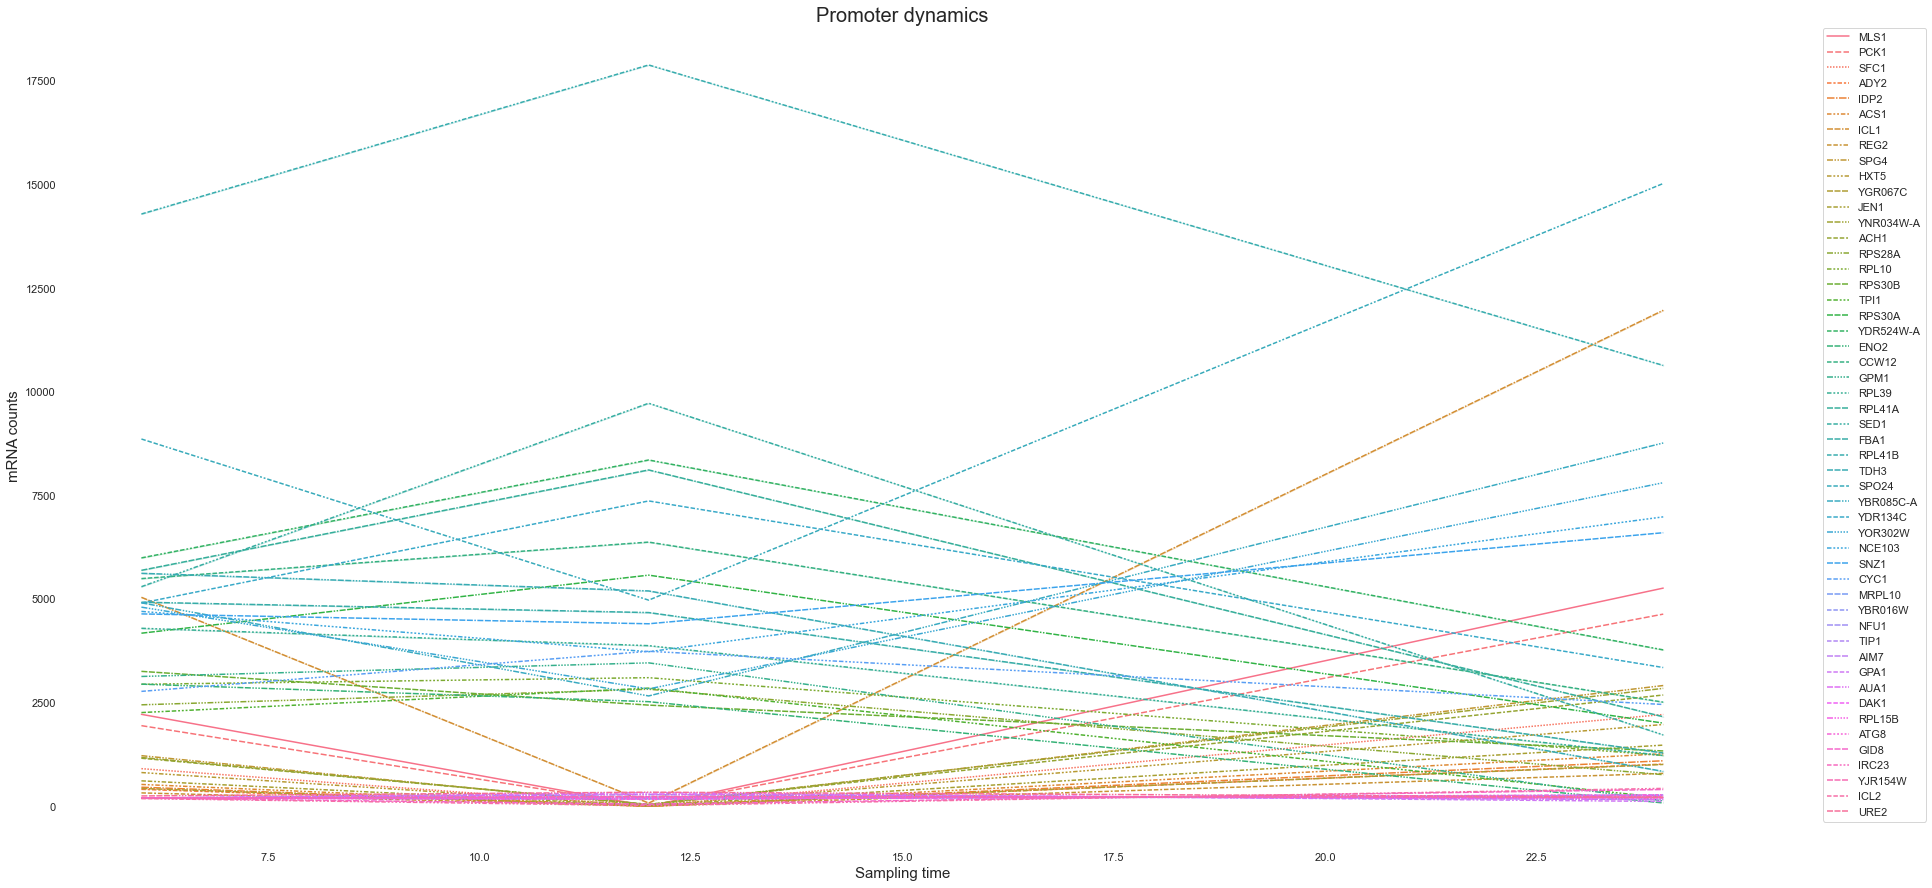

In [40]:

sns.set()
sns.set_style("white")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.0, rc={"lines.linewidth": 0.5})
sns.set(rc={'figure.figsize':(30,15)})
sns.set_style("white")


ax = sns.lineplot(data=df_with_selected_promoters[[6,12,24]].transpose())

# removes the borders around the plot
sns.despine(bottom = True, left = True)
ax.legend(frameon=False) # around the legend
ax.legend(frameon=False) # around the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


# Adding all the titles
ax.set_title("Promoter dynamics",  fontsize=20)
#fig.suptitle("Promoter dynamics", fontsize=20)
ax.set_ylabel("mRNA counts",  fontsize=15)
ax.set_xlabel("Sampling time", fontsize=15)
None

The next exercise is to narrow the search down to only 8 promoters which will be covered in the next section. 

## 5. Final selection of promoters:

### 5.1 Picking HIGH constitutive promoters: 

As mentioned earlier in the notebook the CYC1 promoter is well studied and we want to use that as one of the high constitutive promoters. For the second choice, RPL41B and SPO24 have an extrodinary high mRNA counts that could potentially put too much burden on the host strain so we will exlude those.

In [41]:
List_of_Top15_High_constitutive_prom[:15]

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
RPL41B,14291.10,17886.2000,10638.800
SPO24,8863.45,4976.5900,15027.100
YDR524W-A,5996.15,8357.5800,3777.040
RPL41A,5696.18,8116.9500,2164.460
TDH3,5623.80,5198.4500,845.219
CCW12,5496.46,6376.5400,2516.050
SED1,5301.26,9726.3500,1726.580
ICL1,5044.52,82.0545,11968.600
FBA1,4927.04,4676.8500,1290.280


If we look at the next 5 candidates we notice that some of them have been used in previous studies namely TDH3 and CCW12 (https://academic.oup.com/nar/article/45/1/496/2572058). These two are both active in the exponential phase but TDH drops considerably at the 24 hour mark. Therefore, to ensure more stable expression the CCW12 was chosen as second promoter. 




In [42]:
pHIGH_constitutive = ['CYC1', 'CCW12']

### 5.2 Picking LOW constitutive promoters: 

For the low constitutive we were again using our knowledge of which promoters have worked in the lab and here the URE2 promoter was chosen as one of the low constitutive promoters.

In [43]:
List_of_Top15_Low_constitutive_prom = List_of_Top15_Low_constitutive_prom.sort_values(by=['NIL_6h_FPKM'], ascending = True)
List_of_Top15_Low_constitutive_prom[:15]

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAR035C-A,143.259,0.0000,548.738
ICL2,190.041,20.4447,435.158
YJR154W,195.600,242.9640,210.320
IRC23,196.792,222.5550,232.621
GID8,198.447,54.5051,408.253
ATG8,199.029,172.5420,282.057
RPL15B,200.212,186.5090,258.028
DAK1,200.626,234.5080,205.936
AUA1,203.638,298.2330,165.299


For the second of the low constitutive promoter we are not interested in an sudden drop or increase in  expression and we will therfore drop those ('YAR035C-A', 'ICL2', 'GID8'). Then we have very similar characteristics for the next five promoters and a literature search did not come out fruitful. Arbitrarily the RPL15B promoter was chosen. 


In [44]:
# NON-stable promoters
non_stable_promoters = ['YAR035C-A', 'ICL2', 'GID8']

Updated_Low_constitutive_prom = List_of_Top15_Low_constitutive_prom.drop(non_stable_promoters)

Updated_Low_constitutive_prom[:5].sort_values(by=['NIL_6h_FPKM'], ascending = True)

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YJR154W,195.600,242.964,210.320
IRC23,196.792,222.555,232.621
ATG8,199.029,172.542,282.057
RPL15B,200.212,186.509,258.028
DAK1,200.626,234.508,205.936


In [45]:
pLOW_constitutive = ['RPL15B', 'URE2']

### 5.3 Picking INCREASING promoters: 


Examining the top15 increasing promoters we find that the top promoter increases infinite and which is due to the fact that the previous datapoint is zero. We will remove this as a top candidate and look at the following promoters. Here we see that by far the best candidates are MLS1 and PCK1 and since these are also know from literature it is an easy pick for the increasing promoters.

In [46]:
Top15_increasing_promoters

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAR035C-A,NaN,-1.000000,inf
MLS1,NaN,-0.996357,649.677485
PCK1,NaN,-0.994967,471.973855
SFC1,NaN,-0.988483,210.280874
ADY2,NaN,-0.987649,199.421709
IDP2,NaN,-0.986789,178.798201
ACS1,NaN,-0.986592,177.523269
ICL1,NaN,-0.983734,144.861592
REG2,NaN,-0.980036,121.203096


In [47]:
pINCREASING = ['PCK1', 'MLS1']

### 5.4 Picking DECREASING promoters: 


In [48]:
Top15_decreasing_promoters = Top15_decreasing_promoters.sort_values(by=['NIL_24h_FPKM'], ascending = True)
Top15_decreasing_promoters

,NIL_6h_FPKM,NIL_24h_FPKM
gene_short_name,,
TDH3,NaN,-4778.5810
RPL41B,NaN,-3652.3000
FBA1,NaN,-3636.7600
SED1,NaN,-3574.6800
RPL41A,NaN,-3531.7200
RPL39,NaN,-3067.6400
GPM1,NaN,-3001.3950
CCW12,NaN,-2980.4100
ENO2,NaN,-2865.8586


For the decreasings promoters one thing becomes clear and that is that many of what are considered strong constitutive promoters are found to be in the top, namely TDH3 (http://parts.igem.org/Part:BBa_K124002, https://academic.oup.com/nar/article/45/1/496/2572058). Additionally, the promoter we chose as one of the high constitutive promoters can be found in thin the top 8 (CCW12). As we are not interested in the high constitutive promoters for this category we well cutoff after CCW12. 


In [49]:
Decreasing_promoters = Top15_decreasing_promoters[8:]
Decreasing_promoters

,NIL_6h_FPKM,NIL_24h_FPKM
gene_short_name,,
ENO2,NaN,-2865.8586
YDR524W-A,NaN,-2219.1100
RPS30A,NaN,-2168.9100
TPI1,NaN,-2055.6160
RPS30B,NaN,-1919.9100
RPL10,NaN,-1716.1800
RPS28A,NaN,-1685.1020


Examining this list and cross-referencing with literature the promoters ENO2 and TPI1 are well know from the litterature (https://academic.oup.com/nar/article/45/1/496/2572058, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4480987/) and have been shown to work well in yeast systems. Additionally, the referenced papers also support that the promoters show the pattern of decreasing expression over time. ENO2 and TPI1 are good candidates for this category.

In [50]:
pDECREASING = ['ENO2', 'TPI1']

## 6. Plotting chosen promoters

In [79]:
chosen_promoters = [pHIGH_constitutive, pLOW_constitutive, pINCREASING, pDECREASING]
promoters1, promoters2 = list(), list()

# Taking one promoter from each nested list
for i in range(len(chosen_promoters)):
    promoters1.append(chosen_promoters[i][0])
    promoters2.append(chosen_promoters[i][1])  

print(promoters1)
print(promoters2)


['CYC1', 'RPL15B', 'PCK1', 'ENO2']
['CCW12', 'URE2', 'MLS1', 'TPI1']


 Lets add the reference promotors to the plot

In [80]:
G8H_reference_promoters = ['TDH3']
CPR_reference_promoters = ['TEF1']

promoters1 = promoters1+ G8H_reference_promoters
promoters2 = promoters2+ CPR_reference_promoters
promoters2

['CCW12', 'URE2', 'MLS1', 'TPI1', 'TEF1']

In [81]:
legend1_names = ['p'+name for name in promoters1]
legend2_names = ['p'+name for name in promoters2]
legend2_names

['pCCW12', 'pURE2', 'pMLS1', 'pTPI1', 'pTEF1']

In [82]:
df_with_prom1 = df_with_threshold.loc[promoters1].transpose()
df_with_prom1.index = [6, 12, 24]
df_with_prom2 = df_with_threshold.loc[promoters2].transpose()
df_with_prom2.index = [6, 12, 24]

In [83]:
df_with_prom1

gene_short_name,CYC1,RPL15B,PCK1,ENO2,TDH3
6,2775.83,200.212,1948.90000,2950.2200,5623.800
12,3742.74,186.509,9.80902,2527.2700,5198.450
24,2459.66,258.028,4639.41000,84.3614,845.219


In [84]:
df_with_prom2

gene_short_name,CCW12,URE2,MLS1,TPI1,TEF1
6,5496.46,253.590,2222.16000,2264.780,510.931
12,6376.54,344.076,8.09464,2853.860,420.244
24,2516.05,222.439,5267.00000,209.164,320.136


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_29801/2295238717.py:44: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)


<Figure size 2160x1080 with 0 Axes>

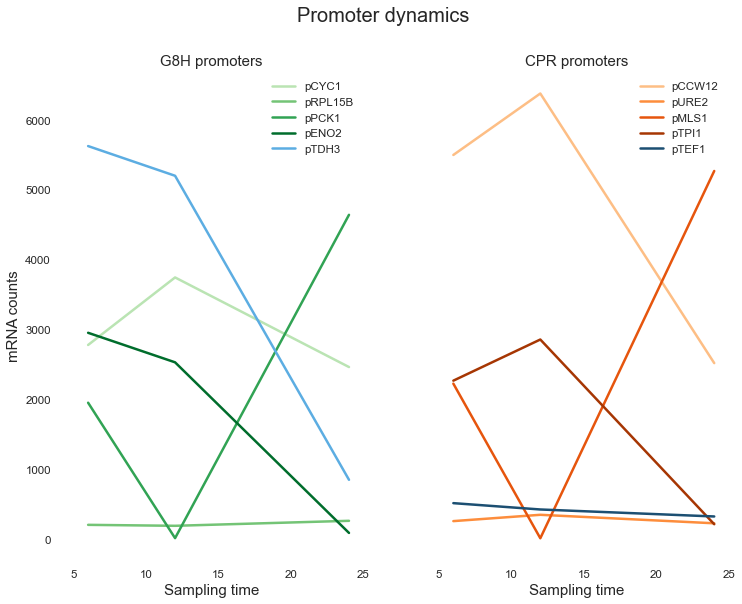

In [85]:
# Plotting an empty subplot
pg8H_color = ['#bae4b3','#74c476','#31a354','#006d2c', '#5cade2']
pcpr_color = ['#fdbe85','#fd8d3c','#e6550d','#a63603', '#1c4f72']

import seaborn as sns
#set seaborn plotting aesthetics as default
sns.set()
sns.set_style("white")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.despine(bottom = True, left = True)

# Plotting an empty subplot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,9), sharey=True)  # 1 row, 2 columns 

# Adding the DFs
ax1 = df_with_prom1.plot( ax=ax1, color = pg8H_color )
ax2 = df_with_prom2.plot( ax=ax2, color = pcpr_color)


# Fixing legend names

sns.despine(bottom = True, left = True)
# removes the borders around the plot

ax1.legend(legend1_names, frameon=False)
ax2.legend(legend2_names, frameon=False)


# changing the range of the x axis
ax1.set_xlim(4,25)
ax2.set_xlim(4,25)

# Adding all the titles
ax1.set_title("G8H promoters",  fontsize=15)
ax2.set_title("CPR promoters",  fontsize=15)
fig.suptitle("Promoter dynamics", fontsize=20)
ax1.set_ylabel("mRNA counts",  fontsize=15)
ax1.set_xlabel("Sampling time", fontsize=15)
ax2.set_ylabel("mRNA counts",  fontsize=15)
ax2.set_xlabel("Sampling time", fontsize=15)

# Getting shared axes
ax1.get_shared_x_axes().join(ax1, ax2)
plt.savefig('ConStrain_on_google_colab/pictures/Dynamics_of_chosen_promoters.pdf',format = 'pdf', dpi = 300)
#plt.savefig('ConStrain_on_google_colab/pictures/Dynamics_of_chosen_promoters.svg',format = 'SVG',  dpi = 120)

#### 6.1 Retrieving first set of promoters from all of the promoters

In [86]:
Promoters_for_fasta = []

for i in range(0, len(All_promoters)): 
    for j in range(0, len(promoters1)): 
        if All_promoters[i].id == promoters1[j]: 
            Promoters_for_fasta.append(All_promoters[i])
        
Promoters_for_fasta

[SeqRecord(seq=Seq('ACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAGA...AAC'), id='PCK1', name='PCK1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='ENO2', name='ENO2 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('CTATTTTCGAGGACCTTGTCACCTTGAGCCCAAGAGAGCCAAGATTTAAATTTT...AAA'), id='TDH3', name='TDH3 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('CTATTTTCGAGGACCTTGTCACCTTGAGCCCAAGAGAGCCAAGATTTAAATTTT...AAA'), id='TDH3', name='TDH3 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('GAGGCACCAGCGTCAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAG...ATA'), id='CYC1', name='CYC1 Promoter', description

#### 6.2 Retrieving second set of promoters from all of the promoters

In [78]:
Promoters_for_fasta1 = []

for i in range(len(All_promoters)): 
    for j in range(len(promoters2)): 
        if All_promoters[i].id == promoters2[j]:
            Promoters_for_fasta1.append(All_promoters[i])

# CCW12 appear twice so lets remove that (it appeared in two different lists)
Promoters_for_fasta1.pop(2)
Promoters_for_fasta1

[SeqRecord(seq=Seq('TTTAATCTTTAGGGAGGGTAAAGTTGGATTCATCAATTTGATGAAATCCGTGTA...AAA'), id='MLS1', name='MLS1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AAGGATGAGCCAAGAATAAGGGAACAAGATTTTGGTAATTTCCAAAAAATCAAT...AAA'), id='TPI1', name='TPI1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AACCAGGGCAAAGCAAAATAAAAGAAACTTAATACGTTATGCCGTAATGAAGGG...ATA'), id='CCW12', name='CCW12 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('GCTGAACTCGCTGAAATTGAAAGAAAACTGGCAGAATCGTCTTCTGAAGACGAA...CAA'), id='URE2', name='URE2 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[])]

## 7. Exporting the sequemces as FASTA file 

In [ ]:
with open('ConStrain_on_google_colab/Data/G8H_CYP_CPR_PARTS/Promoter_sequences_1.fasta', 'w') as outfile:
    for i in range(0, len(Promoters_for_fasta)):
        print(Promoters_for_fasta[i].format("fasta"), file = outfile)

In [ ]:
with open('ConStrain_on_google_colab/Data/G8H_CYP_CPR_PARTS/Promoter_sequences_2.fasta', 'w') as outfile:
    for i in range(0, len(Promoters_for_fasta1)):
        print(Promoters_for_fasta1[i].format("fasta"), file = outfile)

We can asses homology with different tools and one of them is  https://www.ebi.ac.uk/Tools/msa/clustalo/


After running an sequence alignment the following result was obtained: 



In [ ]:
import IPython
IPython.core.display.Image('ConStrain_on_google_colab/pictures/Promoters_homology-1.png', width=800)

In [ ]:
IPython.core.display.Image('ConStrain_on_google_colab/pictures/Promoters_homology-2.png', width=800)

# Refences 

Kotopka, B. and Smolke, C., 2020. Model-driven generation of artificial yeast promoters. Nature Communications, 11(1).

Rajkumar, A., Özdemir, E., Lis, A., Schneider, K., Qin, J., Jensen, M. and Keasling, J., 2019. Engineered Reversal of Function in Glycolytic Yeast Promoters. ACS Synthetic Biology, 8(6), pp.1462-1468.